In [0]:
import pandas as pd
import datetime
import numpy as np
import sklearn
import copy
import tensorflow as tf
import keras
import matplotlib.pyplot as pl
from google.colab import files
import io 
import matplotlib.pyplot as plt

In [0]:
def csv_to_df(folder, filename):
  return pd.read_csv(io.StringIO(folder[filename].decode('utf-8')))

In [0]:
combined_file=files.upload() # when prompted, upload combined_data_271219.csv, if it doesn't work the first time, rerun it

Saving combined_data_030120.csv to combined_data_030120.csv


In [0]:
dengue_file=files.upload() # when prompted, upload dengue_271219.csv

Saving dengue_271219.csv to dengue_271219.csv


In [0]:
population_file=files.upload() #population-sg.csv

Saving population-sg.csv to population-sg.csv


In [0]:
combined_df=csv_to_df(combined_file, 'combined_data_030120.csv')
dengue_df=csv_to_df(dengue_file, 'dengue_271219.csv')
pop_df=csv_to_df(population_file, 'population-sg.csv')

In [0]:
pop_dict={}
for i, j in pop_df.iterrows():
    pop_dict.update({j[0]:int(j[1].replace(',',''))})

pop_df['population']=pop_dict.values()

In [0]:
oo=pd.date_range('1/2/2000', periods=7273)
date_list=oo.to_pydatetime().tolist()

op=dengue_df['Unnamed: 0']
def foo(st):
 y=st.split('-')
 return datetime.datetime(int(y[0]), int(y[1]), int(y[2]))

dt_list=list(map(foo, op))
oo=oo.to_pydatetime().tolist()
combined_df.index=oo

combined_df.drop(['Unnamed: 0'], axis=1, inplace=True)
dengue_df.drop(['Unnamed: 0'], axis=1, inplace=True)

dengue_df.index=dt_list

In [0]:
def rid_duplicates(df):
    return df.loc[~df.index.duplicated(keep='first')]

trancated_dengue=rid_duplicates(dengue_df)

In [0]:
def normaliser(df, *args):
    _=copy.copy(df)
    for i in args:
        ran=_[i].max()-_[i].min()
        std=_[i].std()
        ave=_[i].mean()
        _[i]=(_[i]-ave)/std
    return _

In [0]:
trancated_dengue=normaliser(trancated_dengue, 'dengue')
combined_df=normaliser(combined_df, 'rain_mean', 'temp_mean')
pop_df=normaliser(pop_df, 'population')

In [0]:
def pull_dataframe(date, x, iu, *args, **kwargs):
    idx=date_list.index(date)
    u=pd.DataFrame()
    if idx-x-iu>0:
        for i, text in zip(args, kwargs.values()):
            o=i[idx-x-iu:idx-iu][text]
            u[text]=o
        return u, date
    else:
        return u, date

In [0]:
rainfall_df=pd.DataFrame(combined_df['rain_mean'])
temperature_df=pd.DataFrame(combined_df['temp_mean'])

In [0]:
DATA_WINDOW=16 #should be even
LEAD_TIME=8
MAX_EXTRACT=20 # rainfall window
LCD=6 #should divide DATA_WINDOW or 7, increase to reduce noise

In [0]:
rf_df=pd.DataFrame()
tp_df=pd.DataFrame()

In [0]:
for date in trancated_dengue.index:
    if date in date_list:
        df_pushback, dat=pull_dataframe(date, DATA_WINDOW*7, LEAD_TIME*7, rainfall_df, temperature_df, label1='rain_mean', label2='temp_mean')
    if len(df_pushback)!=0:
        rf_df[dat]=df_pushback['rain_mean'].values
        tp_df[dat]=df_pushback['temp_mean'].values

In [0]:
rf_df

2000-06-19  2000-06-26  2000-07-03  ...  2019-11-11  2019-11-18  2019-11-25
0     -0.310010   -0.073947    3.517442  ...   -0.467996    2.402074   -0.533702
1     -0.538921   -0.314302   -0.212366  ...   -0.544075   -0.301868    1.094485
2      3.938065    2.648656   -0.458087  ...   -0.105665   -0.526974    1.554999
3     -0.405151   -0.492423   -0.591141  ...    0.755671    0.516213   -0.197175
4     -0.575761   -0.546789   -0.592214  ...   -0.371709    1.049969   -0.436049
..          ...         ...         ...  ...         ...         ...         ...
107   -0.465240    0.167482    1.183987  ...   -0.592214   -0.592214    2.543638
108    0.988341    1.731942   -0.518176  ...   -0.592214   -0.592214   -0.590194
109    1.950837    0.768372    0.142803  ...   -0.592214   -0.589988   -0.402553
110   -0.592214   -0.572542   -0.299638  ...   -0.492571   -0.592214   -0.527914
111    0.002595   -0.294273   -0.592214  ...   -0.591884   -0.592214    1.180816

[112 rows x 1011 columns]

In [0]:
def extract_max(df, n , label):
  size=np.argsort(df.values, axis=0)[-n:].T.shape
  ref=np.argsort(df.values, axis=0)[-n:]
  # rainfall_values=rf_df.values.T
  maximum_values=np.zeros((size[0], n))

  for i in range(size[0]):
    for j in range(n):
      pos=ref.T[i][j]
      val=df.values[pos][i]
      maximum_values[i, j]=val

  columns_list=[]
  for i in range(1, n+1):
    columns_list.append(label+str(i))

  maximum_df=pd.DataFrame(maximum_values, columns=columns_list)
  return maximum_df

In [0]:
maximum_rainfall_df=extract_max(rf_df, MAX_EXTRACT, 'rainfallmax')
maximum_temperature_df=extract_max(tp_df, MAX_EXTRACT, 'temperaturemax')

In [0]:
def seven_day_mean(n, d, **kwargs): # where d should be a divisor of n, chooose d smaller for more 'rugged' data
    a=pd.DataFrame()
    for j, df in zip(kwargs.keys(), kwargs.values()):
        for i in range(0, n , d):
            label=str(j)+str( i)
            a[label]=df[i:i+d].mean(axis=0)
    return a

In [0]:
df_seven_day_mean=seven_day_mean(DATA_WINDOW*7, LCD, mean_rain=rf_df, mean_temp=tp_df)

In [0]:
mean_df=pd.DataFrame()

mean_df['temp_mean']=list(tp_df.mean(axis=0))
mean_df['temp_std']=list(tp_df.std(axis=0))
mean_df['temp_min']=list(tp_df.min(axis=0))
mean_df['temp_max']=list(tp_df.max(axis=0))
mean_df['temp_med']=list(tp_df.median(axis=0))

mean_df['rain_mean']=list(rf_df.mean(axis=0))
mean_df['rain_std']=list(rf_df.std(axis=0))
mean_df['rain_min']=list(rf_df.min(axis=0))
mean_df['rain_max']=list(rf_df.max(axis=0))
mean_df['rain_med']=list(rf_df.median(axis=0))

In [0]:
mean_df=mean_df.merge(maximum_rainfall_df, left_index=True, right_index=True)
mean_df=mean_df.merge(maximum_temperature_df, left_index=True, right_index=True)

In [0]:
indexes=df_seven_day_mean.index
df_seven_day_mean.reset_index(drop=True, inplace=True)
mean_df.reset_index(drop=True, inplace=True)

In [0]:
def merge(a, b):
    indexes=a.index
    a.reset_index(drop=True, inplace=True)
    b.reset_index(drop=True, inplace=True)
    for col in b.columns:
        a[col]=b[col]
    a.index=indexes
    return a

mean_df=merge(mean_df, df_seven_day_mean)
mean_df.index=indexes
combined_Data=mean_df

In [0]:
dengue_append=trancated_dengue[trancated_dengue.index>=combined_Data.index[0]]

In [0]:
combined_Data['dengue_actual']=dengue_append['dengue']

In [0]:
pop_df=pop_df[pop_df['year']>=2000]
a=[]
for i in combined_Data.index:
    a.append(pop_dict[i.year])

combined_Data['population']=a

In [0]:
def shift(df, data_window, lead_time):
  dengue_shift=pd.DataFrame()
  for i in range(data_window+lead_time+1):
      dengue_shift[-i]=list(df['dengue'].shift(i))
  for i in range(LEAD_TIME+1):
    dengue_shift.drop([-i], axis=1, inplace=True)
  dengue_shift=dengue_shift.dropna()
  return dengue_shift

In [0]:
dengue_shift=shift(trancated_dengue, DATA_WINDOW, LEAD_TIME)

In [0]:
def average_last_n_cols(df, *args):
  df_average=pd.DataFrame()
  c= copy.copy(df)
  for n in args:
    f=c[c.columns[0:n]]
    average_n=f.mean(axis=1)
    label='ave' + str(n)
    df_average[label]=average_n
  return df_average

In [0]:
ave_intevals=list(np.arange(2, DATA_WINDOW+2, 2))
dengue_average=average_last_n_cols(dengue_shift, *ave_intevals)

In [0]:
dengue_process=merge(dengue_shift, dengue_average)

In [0]:
def df_trend(df, lead_time, data_window):
  dengue_trend=pd.DataFrame()
  dengue_trend['trend']=(df[-data_window-lead_time]-dengue_shift[-lead_time-1])/data_window
  return dengue_trend

def df_str_trend(df, weak, strong, data_window):
  strong_trend=pd.DataFrame()
  weak_label='ave'+str(weak)
  strong_label='ave'+str(strong)
  strong_trend['strong_trend']=(df[strong_label]-dengue_shift[weak_label])/data_window
  return strong_trend

In [0]:
dengue_trend=df_trend(dengue_process, LEAD_TIME, DATA_WINDOW)
strong_trend=df_str_trend(dengue_process, 2, DATA_WINDOW, DATA_WINDOW)

In [0]:
dengue_process=merge(dengue_process, dengue_trend)
dengue_process=merge(dengue_process, strong_trend)
dengue_process['dengue_std']=list(dengue_shift.std(axis=1))

In [0]:
dengue_process_norm=normaliser(dengue_process, 'trend', 'strong_trend')

In [0]:
combined_Data=merge(dengue_process_norm, combined_Data)
combined_Data.index=indexes

In [0]:
combined_Data

-9       -10  ...  dengue_actual  population
2000-06-19 -1.008324 -1.008324  ...      -0.987601     4027887
2000-06-26 -0.980693 -1.008324  ...      -0.918524     4027887
2000-07-03 -0.987601 -0.980693  ...      -0.973785     4027887
2000-07-10 -1.015231 -0.987601  ...      -0.980693     4027887
2000-07-17 -0.973785 -1.015231  ...      -0.973785     4027887
...              ...       ...  ...            ...         ...
2019-10-28  2.224479  2.556049  ...       0.608078     5703569
2019-11-04  1.796202  2.224479  ...       1.063986     5703569
2019-11-11  1.215955  1.796202  ...       1.160694     5703569
2019-11-18  1.133063  1.215955  ...       1.512986     5703569
2019-11-25  1.015632  1.133063  ...       1.243586     5703569

[1011 rows x 117 columns]

In [0]:
combined_Data['year']=combined_Data.index.year
combined_Data['month']=combined_Data.index.month
combined_Data['trend']=list(dengue_trend['trend'])

In [0]:
combined_Data=normaliser(combined_Data, 'year','month', 'population')

In [0]:
def move_dengue_actual_to_back(df):
 a=pd.DataFrame(df['dengue_actual'])
 df.drop(['dengue_actual'], axis=1, inplace=True)
 df['dengue_actual']=a
 return df

In [0]:
df_normalised=move_dengue_actual_to_back(combined_Data)

In [0]:
X=df_normalised.drop('dengue_actual', axis=1)
Y=pd.DataFrame(df_normalised['dengue_actual'])

In [0]:
def euclid_loss(a,b):
    return np.mean((a-b)**2)

def baseline(df):
  a=df[-LEAD_TIME-1]
  b=df['dengue_actual']
  return euclid_loss(a,b), list(a), list(b)

In [0]:
ratio=0.90
train_size=int(len(X)*ratio)
test_size=int(len(X)*(1-ratio));
print(test_size)

101


In [0]:
loss, pred, actual=baseline(df_normalised[-test_size:]); loss

1.0314973708352242

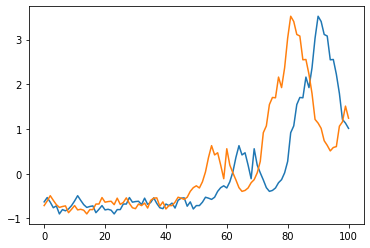

In [0]:
plt.plot(pred)
plt.plot(actual)
plt.show()

In [0]:
X_train=X[:train_size].values
X_test=X[train_size+1:len(X)].values
y_train=Y[:train_size].values
y_test=Y[train_size+1:len(Y)].values

In [0]:
df_normalised.corr()

-9       -10       -11  ...      year     month  dengue_actual
-9             1.000000  0.969347  0.939204  ...  0.292162  0.164610       0.650524
-10            0.969347  1.000000  0.969351  ...  0.292024  0.167784       0.617937
-11            0.939204  0.969351  1.000000  ...  0.291770  0.170775       0.582063
-12            0.901869  0.939212  0.969345  ...  0.291519  0.170007       0.550443
-13            0.856587  0.902067  0.939358  ...  0.290692  0.164310       0.519392
...                 ...       ...       ...  ...       ...       ...            ...
mean_temp108   0.194363  0.183473  0.163740  ...  0.267006  0.386471       0.222552
population     0.285678  0.285842  0.285888  ...  0.979026 -0.042414       0.287353
year           0.292162  0.292024  0.291770  ...  1.000000 -0.049988       0.296084
month          0.164610  0.167784  0.170775  ... -0.049988  1.000000       0.055381
dengue_actual  0.650524  0.617937  0.582063  ...  0.296084  0.055381       1.000000

[119 rows x 119 columns]

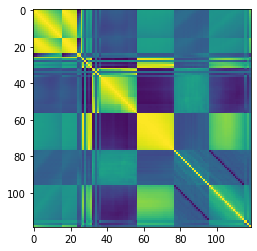

In [0]:
plt.imshow(df_normalised.corr())

In [0]:
print(X_train.shape, y_train.shape)

(909, 118) (909, 1)


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
LeakyRelu=keras.layers.LeakyReLU(alpha=0.3)

In [0]:
model = Sequential()
model.add(LSTM(256, input_shape=(1, X_train.shape[2]), activation=LeakyRelu, return_sequences=True))

model.add(LSTM(128, activation=LeakyRelu))
model.add(Dropout(0.1))

model.add(Dense(98, activation=LeakyRelu))
model.add(Dropout(0.1))

# model.add(LSTM(64, activation=LeakyRelu, return_sequences=True))

model.add(Dense(64, activation=LeakyRelu))
model.add(Dropout(0.1))

model.add(Dense(32, activation=LeakyRelu))
model.add(Dropout(0.1))

model.add(Dense(1, activation=tf.nn.elu))
Adam=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.999, amsgrad=True, decay=0.0001)
SGD = tf.keras.optimizers.SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=SGD,
              loss='mean_squared_error',)

In [0]:
history=model.fit(X_train, 
                  y_train, 
                  epochs=70,
                  batch_size=64, 
#                   callbacks = [callback],
                  validation_data=(X_test, y_test), 
                  verbose=1,)

Train on 909 samples, validate on 101 samples
Epoch 1/70
909/909 [==============================] - 13s 14ms/sample - loss: 0.9595 - val_loss: 1.3237
Epoch 2/70
909/909 [==============================] - 0s 383us/sample - loss: 0.9519 - val_loss: 1.3111
Epoch 3/70
909/909 [==============================] - 0s 368us/sample - loss: 0.9378 - val_loss: 1.2853
Epoch 4/70
909/909 [==============================] - 0s 396us/sample - loss: 0.9135 - val_loss: 1.2353
Epoch 5/70
909/909 [==============================] - 0s 363us/sample - loss: 0.8756 - val_loss: 1.1719
Epoch 6/70
909/909 [==============================] - 0s 374us/sample - loss: 0.8308 - val_loss: 1.0935
Epoch 7/70
909/909 [==============================] - 0s 370us/sample - loss: 0.7632 - val_loss: 0.9739
Epoch 8/70
909/909 [==============================] - 0s 386us/sample - loss: 0.6808 - val_loss: 0.8419
Epoch 9/70
909/909 [==============================] - 0s 376us/sample - loss: 0.6104 - val_loss: 0.7603
Epoch 10/70
909/90

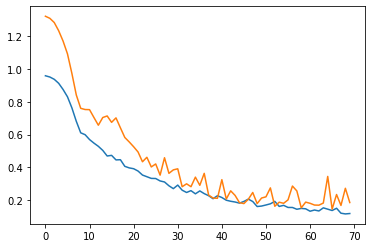

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

0.1836457886459435

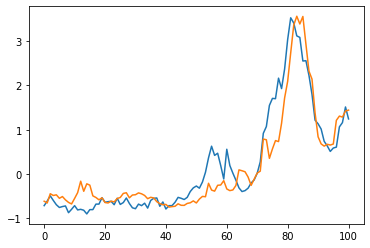

In [0]:
p=model.predict(X_test)
plt.plot(y_test)    
plt.plot(p)
euclid_loss(y_test, p)